# From experiments 1, 2 and 3

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from featureExtractor import InceptionFeatureExtractor

import os
import glob
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image_w = 1920
image_h = 1080
dummy_img = torch.zeros(1, 3, image_h, image_w).float()

In [3]:
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")

Output shape: torch.Size([1, 2048, 32, 58])
Number of channels: 2048
Spatial dimensions: 32x58


# Experiment 4

In [4]:
import torch
from torchvision.ops import box_iou, box_convert

def generate_base_anchors(scales, aspect_ratios, down_h, down_w):
    ctr_y, ctr_x = down_h/2.0, down_w/2.0
    A = len(scales) * len(aspect_ratios)
    base = np.zeros((A,4), dtype=np.float32)
    idx = 0
    for s in scales:
        for ar in aspect_ratios:
            h = down_h * s * np.sqrt(ar)
            w = down_w * s * np.sqrt(1/ar)
            base[idx,0] = ctr_y - h/2.0  # y_min
            base[idx,1] = ctr_x - w/2.0  # x_min
            base[idx,2] = ctr_y + h/2.0  # y_max
            base[idx,3] = ctr_x + w/2.0  # x_max
            idx += 1
    return base

def generate_anchor_boxes(fmap_size, base_anchors, down_h, down_w):
    Hf, Wf = fmap_size
    shift_y = np.arange(0, Hf) * down_h
    shift_x = np.arange(0, Wf) * down_w
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.stack([shift_y.ravel(), shift_x.ravel(),
                       shift_y.ravel(), shift_x.ravel()], axis=1)
    K = shifts.shape[0]; A = base_anchors.shape[0]
    all_ = base_anchors.reshape((1,A,4)) + shifts.reshape((K,1,4))
    return all_.reshape((K*A,4))

def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    
    assert mode in ['a2p','p2a']
    B = bboxes.size(0)
    flat = bboxes.clone().view(B, -1, 4)
    mask = (flat == -1)  

    if mode == 'a2p':
        # y dims [0,2] scale by height, x dims [1,3] by width
        flat[:,:, [0,2]] *= height_scale_factor
        flat[:,:, [1,3]] *= width_scale_factor
    else:
        flat[:,:, [0,2]] /= height_scale_factor
        flat[:,:, [1,3]] /= width_scale_factor

    # restore padding
    flat[mask] = -1
    return flat.view_as(bboxes)


def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):
   
    device = anc_boxes_all.device
    # flatten anchors to (B, M, 4)
    anc_flat = anc_boxes_all.view(batch_size, -1, 4)
    M = anc_flat.size(1)
    N = gt_bboxes_all.size(1)

    ious = torch.zeros((batch_size, M, N), device=device)
    for b in range(batch_size):
        anc = anc_flat[b]               # (M,4)
        gt  = gt_bboxes_all[b]         # (N,4)
        # mask out padded GT.
        valid = (gt[:,0] >= 0)
        if valid.any():
            gt_valid = gt[valid]
            iou_b   = box_iou(anc, gt_valid)  # (M, num_valid)
            # write back only into the valid columns
            ious[b,:,valid] = iou_b
    return ious


def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    
    # convert to cxcywh
    anc_cxywh = box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_cxywh  = box_convert(gt_bbox_mapping,  in_fmt='xyxy', out_fmt='cxcywh')

    anc_cx, anc_cy, anc_w, anc_h = anc_cxywh.unbind(dim=1)
    gt_cx,  gt_cy,  gt_w,  gt_h    = gt_cxywh.unbind(dim=1)

    tx = (gt_cx - anc_cx) / anc_w
    ty = (gt_cy - anc_cy) / anc_h
    tw = torch.log(gt_w  / anc_w)
    th = torch.log(gt_h  / anc_h)

    return torch.stack([tx, ty, tw, th], dim=1)


def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all,
                    pos_thresh=0.7, neg_thresh=0.2):
   
    B, H, W, A, _ = anc_boxes_all.shape
    M = H * W * A
    N = gt_bboxes_all.size(1)

    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)

    max_iou_per_gt, _ = iou_mat.max(dim=1, keepdim=True)  # [B,1,N]
    pos_mask = (iou_mat == max_iou_per_gt) & (max_iou_per_gt > 0)
    # also any anchor > pos_thresh
    pos_mask |= (iou_mat > pos_thresh)

    pos_mask_flat = pos_mask.view(-1, N)      # [(B*M), N]
    pos_any       = pos_mask_flat.any(dim=1)  # [(B*M)]
    positive_inds = torch.where(pos_any)[0]


    max_iou_per_anchor, anchor_to_gt = iou_mat.max(dim=2)  # [B, M]
    conf_scores = max_iou_per_anchor.view(-1)[positive_inds]

    cls_expand = gt_classes_all.unsqueeze(1).expand(B, M, N)
    class_map = torch.gather(cls_expand, 2, anchor_to_gt.unsqueeze(-1)).squeeze(-1)
    class_map = class_map.view(-1)
    GT_class_pos = class_map[positive_inds]

    bboxes_expand = gt_bboxes_all.unsqueeze(1).expand(B, M, N, 4)
    gt_box_for_anchor = torch.gather(
        bboxes_expand,
        2,
        anchor_to_gt.view(B, M, 1, 1).repeat(1,1,1,4)
    ).squeeze(2)
    gt_box_for_anchor = gt_box_for_anchor.view(-1,4)[positive_inds]

    anc_flat = anc_boxes_all.view(-1,4)
    pos_coords = anc_flat[positive_inds]

    offsets = calc_gt_offsets(pos_coords, gt_box_for_anchor)

    neg_any = max_iou_per_anchor.view(-1) < neg_thresh
    neg_inds = torch.where(neg_any)[0]
    idx = torch.randperm(neg_inds.numel(), device=neg_inds.device)[:positive_inds.numel()]
    negative_inds = neg_inds[idx]
    neg_coords = anc_flat[negative_inds]

    return (
        positive_inds,        # long tensor [#pos]
        negative_inds,        # long tensor [#pos]
        conf_scores,          # float tensor [#pos]
        offsets,              # float tensor [#pos,4]
        GT_class_pos,         # long tensor [#pos]
        pos_coords,           # float tensor [#pos,4]
        neg_coords,           # float tensor [#pos,4]
        None                  # placeholder for per-image indexing if needed
    )

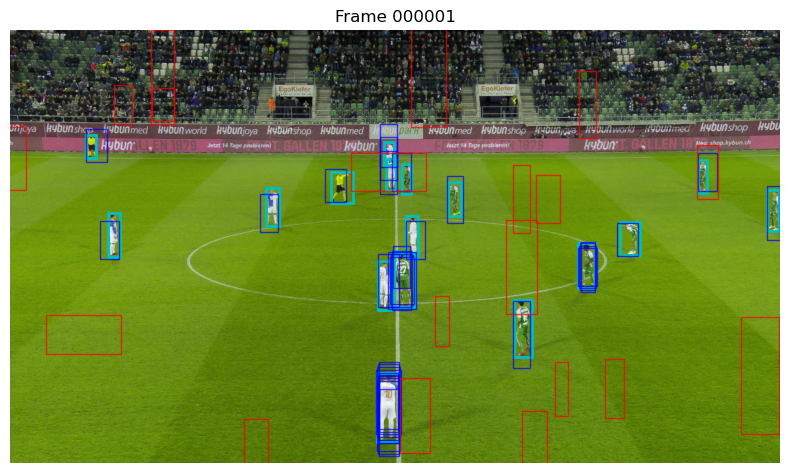

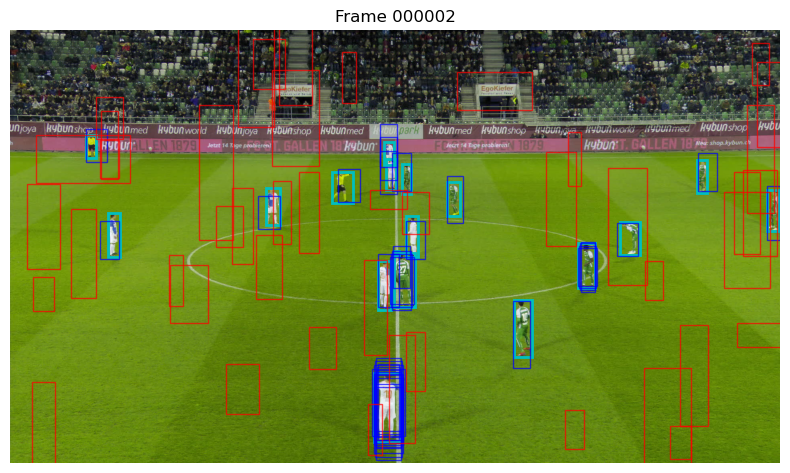

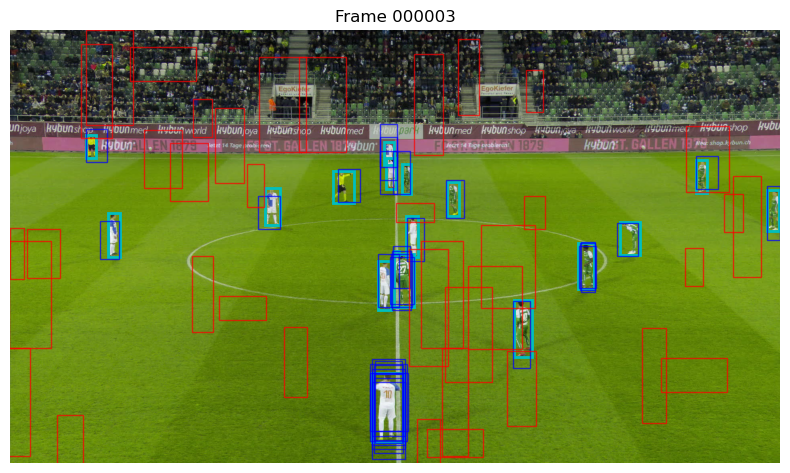

In [5]:
import os, glob
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#
seq_root    = "../soccernet_data/tracking/train/SNMOT-060"
img_dir     = os.path.join(seq_root, "img1")
gt_frame_dir= os.path.join(seq_root, "gt-frame")

img_paths = sorted(glob.glob(os.path.join(img_dir,"*.jpg")))[:3]
frame_ids = [os.path.basename(p).split(".")[0] for p in img_paths]
B = len(img_paths)

# 2) load PIL images + GT boxe
pil_imgs    = []
gt_boxes_all= []   # padded [B, N, 4] as [ymin,xmin,ymax,xmax]
gt_classes  = []   # [B, N]
orig_sizes  = []   # (h,w)
for p,fid in zip(img_paths, frame_ids):
    img = Image.open(p).convert("RGB")
    w,h = img.size
    orig_sizes.append((h,w))
    pil_imgs.append(img)
    
    
    path_txt = os.path.join(gt_frame_dir, f"{fid}.txt")
    lines = open(path_txt).read().splitlines()
    boxes = []
    for L in lines:
        _, ymin, xmin, ymax, xmax = L.split(",")
        boxes.append([float(ymin), float(xmin), float(ymax), float(xmax)])
    boxes = torch.tensor(boxes, dtype=torch.float32)
    cls   = torch.ones((boxes.size(0),), dtype=torch.int64)
    gt_boxes_all.append(boxes)
    gt_classes.append(cls)


N = max(b.size(0) for b in gt_boxes_all)
for i in range(B):
    n    = gt_boxes_all[i].size(0)
    if n < N:
        pad_b = torch.full((N-n,4), -1.0)
        pad_c = torch.zeros((N-n,), dtype=torch.int64)
        gt_boxes_all[i]  = torch.cat([gt_boxes_all[i], pad_b], dim=0)
        gt_classes[i]    = torch.cat([gt_classes[i],    pad_c], dim=0)

gt_bboxes_all = torch.stack(gt_boxes_all, dim=0)   # [B, N,4]
gt_classes_all= torch.stack(gt_classes,   dim=0)   # [B, N]

# extract feature‐maps
feat_ext = InceptionFeatureExtractor().eval()
transform= T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
features = []
for img in pil_imgs:
    x = transform(img).unsqueeze(0)             # [1,3,H,W]
    with torch.no_grad():
        f = feat_ext(x)                        # [1,C,fH,fW]
    features.append(f)

# assume all have same fH,fW → get scale factors
fH, fW = features[0].shape[2], features[0].shape[3]
h_orig, w_orig = orig_sizes[0]
down_h = h_orig / fH
down_w = w_orig / fW

# generate anchors on feature‐grid
scales        = [2, 2.5, 3, 3.5, 4, 5]
aspect_ratios = [0.5, 1.5, 2.0, 2.5, 3, 3.5, 4]
base_anchors = generate_base_anchors(scales, aspect_ratios, down_h, down_w)
# flat → (fH*fW*A,4)
anchors_flat = generate_anchor_boxes((fH,fW), base_anchors, down_h, down_w)
A = len(scales)*len(aspect_ratios)

# reshape → [fH, fW, A,4] → batch → [B,fH,fW,A,4]
anc = torch.from_numpy(anchors_flat).float()
anc = anc.view(fH, fW, A, 4)
anc_boxes_all = anc.unsqueeze(0).repeat(B,1,1,1,1)


# 6) match anchors ↔ gt
pos_thresh, neg_thresh = 0.7, 0.3
(pos_inds, neg_inds, ious, offs, cls_pos,
 pos_coords, neg_coords, _sep) = get_req_anchors(
     anc_boxes_all, gt_bboxes_all, gt_classes_all,
     pos_thresh=pos_thresh, neg_thresh=neg_thresh)

# flatten‐per­image count
M = fH * fW * A
# derive which batch each anchor came from
pos_batch = pos_inds // M
neg_batch = neg_inds // M



import matplotlib.pyplot as plt
import matplotlib.patches as patches

M = fH * fW * A  # total anchors per image


pos_pix = pos_coords   # already in pixel‐coords!
neg_pix = neg_coords   # already in pixel‐coords!


for b in range(B):
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    ax.imshow(pil_imgs[b])
    ax.set_title(f"Frame {frame_ids[b]}")
    ax.axis("off")

    # Ground‐truth in cyan
    for box in gt_bboxes_all[b]:
        if (box<0).any(): continue
        y0,x0,y1,x1 = box.tolist()
        ax.add_patch(patches.Rectangle((x0,y0), x1-x0, y1-y0,
                                       edgecolor='c', facecolor='none', lw=2))

    # Positives in blue
    sel_pos = (pos_batch==b).nonzero(as_tuple=False).squeeze(-1)
    for i in sel_pos:
        y0,x0,y1,x1 = pos_pix[i].tolist()
        ax.add_patch(patches.Rectangle((x0,y0), x1-x0, y1-y0,
                                       edgecolor='b', facecolor='none',
                                       lw=1, alpha=0.7))

    # Negatives in red
    sel_neg = (neg_batch==b).nonzero(as_tuple=False).squeeze(-1)
    for i in sel_neg:
        y0,x0,y1,x1 = neg_pix[i].tolist()
        ax.add_patch(patches.Rectangle((x0,y0), x1-x0, y1-y0,
                                       edgecolor='r', facecolor='none',
                                       lw=1, alpha=0.7))

    plt.tight_layout()
    plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import box_convert, nms


# ----------------------------
# 1) losses for RPN training
# ----------------------------
def calc_cls_loss(conf_pos, conf_neg):

    pos_labels = torch.ones_like(conf_pos)
    neg_labels = torch.zeros_like(conf_neg)
    loss_pos   = F.binary_cross_entropy_with_logits(conf_pos, pos_labels, reduction='mean')
    loss_neg   = F.binary_cross_entropy_with_logits(conf_neg, neg_labels, reduction='mean')
    return 0.5 * (loss_pos + loss_neg)


def calc_bbox_reg_loss(gt_offsets, pred_offsets):

    return F.smooth_l1_loss(pred_offsets, gt_offsets, reduction='mean')


# ---------------------------------------
# 2) ProposalModule and generate_proposals
# ---------------------------------------
class ProposalModule(nn.Module):
    def __init__(self, in_channels, hidden_dim=512, n_anchors=9, p_dropout=0.3):
        super().__init__()
        self.n_anchors = n_anchors
        self.conv1     = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.dropout   = nn.Dropout(p_dropout)
        self.conf_head = nn.Conv2d(hidden_dim,       n_anchors,   kernel_size=1)
        self.reg_head  = nn.Conv2d(hidden_dim, 4*n_anchors,   kernel_size=1)

    def forward(self, feature_map,
                      pos_anc_ind=None,
                      neg_anc_ind=None,
                      pos_anc_coords=None):
        x = F.relu(self.conv1(feature_map))
        x = self.dropout(x)

        conf_logits = self.conf_head(x)    # (B, A, H, W)
        reg_offsets = self.reg_head(x)     # (B, 4A, H, W)

        # eval/inference mode
        if pos_anc_ind is None:
            return conf_logits, reg_offsets

        # training mode
        B, A, H, W = conf_logits.shape
        M = B * A * H * W

        # flatten conf: [M]  
        cflat = conf_logits.permute(0,2,3,1).reshape(-1)
        conf_pos = cflat[pos_anc_ind]
        conf_neg = cflat[neg_anc_ind]

        # flatten offsets: [M,4]
        offlat = reg_offsets.permute(0,2,3,1).reshape(-1,4)
        offs_pos = offlat[pos_anc_ind]

        # turn positive anchors + their offsets into proposals
        proposals = generate_proposals(pos_anc_coords, offs_pos)

        return conf_pos, conf_neg, offs_pos, proposals


def generate_proposals(anchors_xyxy, offsets):
    """
    anchors_xyxy: [N,4] in (ymin,xmin,ymax,xmax)
    offsets:      [N,4] in (t_x, t_y, t_w, t_h)
    """
    # to (cx,cy,w,h)
    anc_cxywh = box_convert(anchors_xyxy, in_fmt='xyxy', out_fmt='cxcywh')
    cx, cy, w, h     = anc_cxywh.unbind(dim=1)
    dx, dy, dw, dh   = offsets.unbind(dim=1)

    pcx = cx + dx * w
    pcy = cy + dy * h
    pw  = w   * torch.exp(dw)
    ph  = h   * torch.exp(dh)

    prop_cxywh = torch.stack([pcx, pcy, pw, ph], dim=1)
    # back to xyxy
    return box_convert(prop_cxywh, in_fmt='cxcywh', out_fmt='xyxy')


# ----------------------------------------
# Adapted RegionProposalNetwork
# ----------------------------------------
class RegionProposalNetwork(nn.Module):
    def __init__(self,
                 img_size,      # (H_img, W_img)
                 fmap_size,     # (H_map, W_map)
                 feat_channels, # e.g. 2048 from InceptionFeatureExtractor
                 anc_scales= [2, 2.5, 3, 3.5, 4, 5],
                 anc_ratios =[0.5, 1.5, 2.0, 2.5, 3, 3.5, 4],
                 pos_thresh=0.5,
                 neg_thresh=0.3):
        super().__init__()
        self.H_img, self.W_img = img_size
        self.H_map, self.W_map = fmap_size

        # how many pixels per activation‐cell
        self.h_scale = self.H_img // self.H_map
        self.w_scale = self.W_img // self.W_map

        self.anc_scales = anc_scales
        self.anc_ratios = anc_ratios
        self.n_anchors  = len(anc_scales) * len(anc_ratios)

        self.pos_thresh = pos_thresh
        self.neg_thresh = neg_thresh

        self.feature_extractor = InceptionFeatureExtractor()
        self.proposal_module   = ProposalModule(feat_channels,
                                                n_anchors=self.n_anchors)

    def forward(self, images, gt_bboxes, gt_classes):
        """
        images:    [B,3,H_img,W_img]
        gt_bboxes: [B,N,4] padded, in xyxy
        gt_classes:[B,N]
        """
        device = images.device
        B = images.size(0)
        # 1) feature map
        feat_map = self.feature_extractor(images)  # [B,C,H_map,W_map]

        # 2) build anchors (pixel‐space)
        base = generate_base_anchors(self.anc_scales,
                                     self.anc_ratios,
                                     self.h_scale,
                                     self.w_scale)       # [A,4]
        flat = generate_anchor_boxes((self.H_map,self.W_map),
                                     base,
                                     self.h_scale,
                                     self.w_scale)       # [H*W*A,4]
        # reshape → [H_map,W_map,A,4] → [B,H_map,W_map,A,4]
        anc = (torch.from_numpy(flat)
                     .float()
                     .view(self.H_map, self.W_map, self.n_anchors, 4)
                     .unsqueeze(0)
                     .repeat(B,1,1,1,1)
                     .to(device)            # ← move to MPS here
             )

        # 3) project GT boxes into activation‐space
        gt_proj = project_bboxes(gt_bboxes,
                                 width_scale_factor=self.w_scale,
                                 height_scale_factor=self.h_scale,
                                 mode='p2a')

        # 4) sample positives/negatives
        (pos_inds, neg_inds,
         GT_conf, GT_offs, GT_cls,
         pos_anc_xy, neg_anc_xy,
        _sep) = get_req_anchors(anc, gt_proj, gt_classes,
                               self.pos_thresh, self.neg_thresh)

        # 5) RPN heads
        conf_pos, conf_neg, offs_pos, proposals = \
            self.proposal_module(feat_map,
                                 pos_inds, neg_inds, pos_anc_xy)

        # 6) losses
        cls_loss = calc_cls_loss(conf_pos, conf_neg)
        reg_loss = calc_bbox_reg_loss(GT_offs, offs_pos)

        total = cls_loss + 5.0*reg_loss
        return total, feat_map, proposals, _sep, GT_cls

    @torch.no_grad()
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        """
        Returns a list of (proposals, scores) per image.
        """
        device = images.device
        B = images.size(0)
        feat_map = self.feature_extractor(images)

        # rebuild the same anchors
        base = generate_base_anchors(self.anc_scales,
                                     self.anc_ratios,
                                     self.h_scale,
                                     self.w_scale)
        flat = generate_anchor_boxes((self.H_map,self.W_map),
                                     base,
                                     self.h_scale,
                                     self.w_scale)
        anc = (torch.from_numpy(flat)
                   .float()
                   .view(self.H_map, self.W_map, self.n_anchors, 4)
                   .unsqueeze(0)
                   .repeat(B,1,1,1,1)
                   .to(device)            # ← and here
              )
        anc_flat = anc.reshape(B, -1, 4)

        # RPN heads
        conf_logits, reg_offsets = self.proposal_module(feat_map)
        scores = torch.sigmoid(conf_logits).reshape(B, -1)
        offs   = reg_offsets.reshape(B, -1, 4)

        results = []
        for i in range(B):
            sc  = scores[i]
            of  = offs[i]
            ac  = anc_flat[i]
            props = generate_proposals(ac, of)
            keep1 = torch.where(sc>=conf_thresh)[0]
            props = props[keep1]; sc = sc[keep1]
            keep2 = nms(props, sc, nms_thresh)
            results.append((props[keep2], sc[keep2]))

        return results

In [9]:
device = torch.device("mps")
H_img, W_img = 800, 800 # Size after transforms
dummy_input = torch.randn(1, 3, H_img, W_img).to(device)
# Instantiate feature extractor temporarily
temp_extractor = InceptionFeatureExtractor().to(device)
temp_extractor.eval() # Set to eval mode
with torch.no_grad():
    dummy_features = temp_extractor(dummy_input)
H_map = dummy_features.shape[2]
W_map = dummy_features.shape[3]
feat_ch = dummy_features.shape[1]
print(f"Determined Feature Map Size: H={H_map}, W={W_map}, C={feat_ch}")
del temp_extractor

Determined Feature Map Size: H=23, W=23, C=2048


In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 0) select device
device = torch.device("cpu")
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")


device = torch.device("cpu")
print("Using device:", device)

# 1) build RPN
H_img, W_img = pil_imgs[0].size[1], pil_imgs[0].size[0]  # note: PIL gives (W,H)
# H_map, W_map = features[0].shape[2], features[0].shape[3]
feat_ch = features[0].shape[1]

rpn = RegionProposalNetwork(
    img_size   =(H_img, W_img),
    fmap_size  =(H_map, W_map),
    feat_channels=feat_ch
).to(device)

# experiments/exp4_train_with_dataloader.py
import os
import torch
import torch.optim as optim
import torchvision.transforms as T
from data_loader import get_dataloader



# 2) Hyperparameters and data paths
sequence_dir = os.path.join("..", "soccernet_data", "tracking", "train", "SNMOT-060")
batch_size = 4
num_workers = 0
n_epochs = 20
lr = 1e-4

# 3) Image transforms
y_transform = T.Compose([
    T.Resize((800, 800)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# 4) Initialize DataLoader
loader = get_dataloader(
    sequence_dir,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    transforms=y_transform
)

# 5) Prepare the RPN (assumes `rpn` is already defined in the environment)
rpn.to(device)
# Freeze backbone parameters
for p in rpn.feature_extractor.parameters():
    p.requires_grad = False

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, rpn.parameters()),
    lr=lr
)

# 6) Training loop
for epoch in range(1, n_epochs + 1):
    rpn.train()
    epoch_loss = 0.0
    for images, targets in loader:
        # Move images to device
        images = [img.to(device) for img in images]

        # Pad targets in batch to same number of boxes
        max_boxes = max([t["boxes"].shape[0] for t in targets])
        gt_boxes = []
        gt_labels = []
        for t in targets:
            b, l = t["boxes"], t["labels"]
            n = b.shape[0]
            if n < max_boxes:
                pad_b = torch.zeros((max_boxes - n, 4), device=device)
                pad_l = torch.zeros((max_boxes - n,), dtype=torch.int64, device=device)
                b = torch.cat([b.to(device), pad_b], dim=0)
                l = torch.cat([l.to(device), pad_l], dim=0)
            else:
                b = b.to(device)
                l = l.to(device)
            gt_boxes.append(b)
            gt_labels.append(l)
        # Stack into tensors of shape [B, N, ...]
        gt_boxes = torch.stack(gt_boxes, dim=0)
        gt_labels = torch.stack(gt_labels, dim=0)

        # Forward + backward
        optimizer.zero_grad()
        loss, _, _, _, _ = rpn(torch.stack(images, dim=0), gt_boxes, gt_labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f"[Epoch {epoch}/{n_epochs}] RPN loss = {avg_loss:.4f}") 

Using device: cpu


/var/folders/nz/1rwtt6tx04jf15ng2v_zh71h0000gn/T/ipykernel_4396/803672936.py:107: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Scalar.cpp:23.)
  epoch_loss += loss.item()


[Epoch 1/20] RPN loss = 2.3338
[Epoch 2/20] RPN loss = 0.8307
[Epoch 3/20] RPN loss = 0.6270
[Epoch 4/20] RPN loss = 0.5247


[Epoch 001/020] RPN loss = 7.0897
[Epoch 010/020] RPN loss = 1.7886
[Epoch 020/020] RPN loss = 1.1405


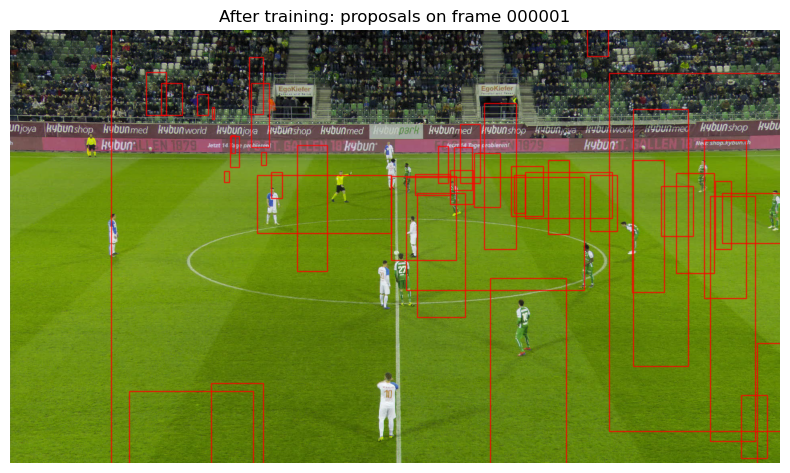

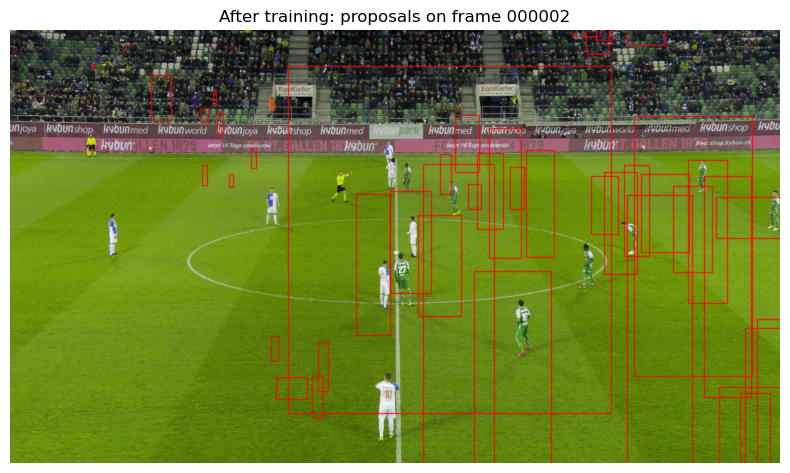

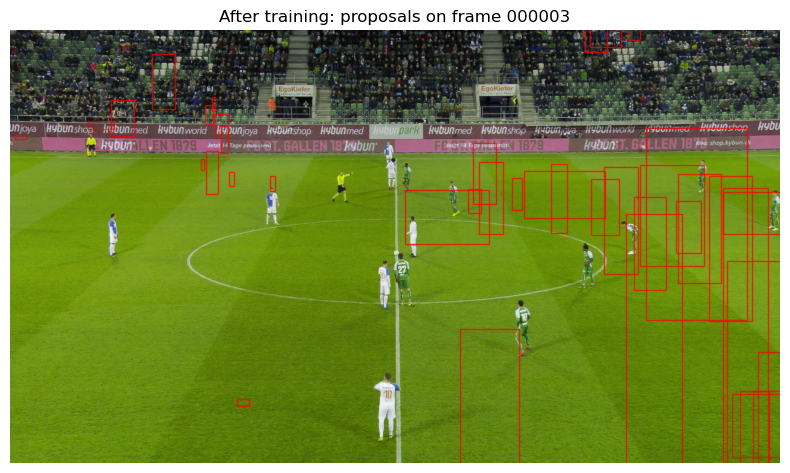